In [1]:
# --- Step 1: Import All Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re

# Import Google Sheets libraries
try:
    import gspread
    from google.colab import auth
    from google.auth import default
    from gspread_dataframe import set_with_dataframe
    print("All libraries imported.")
except ImportError:
    print("Installing Google libraries...")
    !pip install gspread google-auth google-auth-oauthlib gspread-dataframe

    import gspread
    from google.colab import auth
    from google.auth import default
    from gspread_dataframe import set_with_dataframe
    print("Libraries installed and imported.")

# --- Step 2: Load and Clean Data ---
print("\n--- Loading and Cleaning Data ---")
file_path = 'amazon.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Original 'amazon.csv' loaded successfully. Original data has {len(df)} rows.")
except FileNotFoundError:
    print(f"FATAL ERROR: The file '{file_path}' was not found.")
    print("Please upload 'amazon.csv' to the main /content/ folder and try again.")
    raise

# Handle missing values
df_cleaned = df.dropna(subset=['rating_count'])

# Create a working copy
df_cleaned = df_cleaned.copy()

# Clean price columns
df_cleaned['discounted_price'] = df_cleaned['discounted_price'].str.replace('₹', '').str.replace(',', '')
df_cleaned['actual_price'] = df_cleaned['actual_price'].str.replace('₹', '').str.replace(',', '')

# Clean discount_percentage
df_cleaned['discount_percentage'] = df_cleaned['discount_percentage'].str.replace('%', '')

# Clean rating (filter out non-numeric rows)
df_cleaned = df_cleaned[pd.to_numeric(df_cleaned['rating'], errors='coerce').notnull()]

# Clean rating_count
df_cleaned['rating_count'] = df_cleaned['rating_count'].str.replace(',', '')

# Convert all columns to numeric types
df_cleaned['discounted_price'] = pd.to_numeric(df_cleaned['discounted_price'])
df_cleaned['actual_price'] = pd.to_numeric(df_cleaned['actual_price'])
df_cleaned['discount_percentage'] = pd.to_numeric(df_cleaned['discount_percentage'])
df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'])
df_cleaned['rating_count'] = pd.to_numeric(df_cleaned['rating_count'])

print(f"Data cleaned. {len(df_cleaned)} rows remain.") # Should be 1462

if len(df_cleaned) != 1462:
    print(f"WARNING: Expected 1462 rows after cleaning, but found {len(df_cleaned)}. Proceeding anyway...")

# --- Step 3: Feature Engineering ---
print("\n--- Engineering Features ---")
df_cleaned['discount_amount'] = df_cleaned['actual_price'] - df_cleaned['discounted_price']
df_cleaned['category_main'] = df_cleaned['category'].str.split('|').str[0]
print("New features 'discount_amount' and 'category_main' created.")

# --- Step 4: Aggressive Text Cleaning ---
print("\n--- Aggressively Cleaning Text Fields ---")
def aggressively_clean_text(text):
    if isinstance(text, str):
        # This function will encode the string to 'utf-8', ignoring any bad characters,
        # and then decode it back to a clean 'utf-8' string.
        return text.encode('utf-8', errors='ignore').decode('utf-8')
    return text

text_columns = df_cleaned.select_dtypes(include=['object']).columns
for col in text_columns:
    df_cleaned[col] = df_cleaned[col].apply(aggressively_clean_text)
print("Text cleaning complete.")

# --- Step 5: Authenticate with Google ---
print("\n--- Authenticating with Google ---")
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
print("Authentication successful.")

# --- Step 6: Write to Google Sheets ---
print("\n--- Writing to Google Sheets ---")
sheet_name = 'Amazon Sales Data (Cleaned)'
try:
    # Try to open the sheet first
    sh = gc.open(sheet_name)
    print(f"Opened existing Google Sheet: '{sheet_name}'")
except gspread.exceptions.SpreadsheetNotFound:
    # If it doesn't exist, create it
    sh = gc.create(sheet_name)
    print(f"Created new Google Sheet: '{sheet_name}'")

# Open the first worksheet
worksheet = sh.get_worksheet(0)

# Convert all data to string (safer for Google Sheets)
df_for_sheets = df_cleaned.astype(str)

# Clear the sheet first before writing
worksheet.clear()

# Write the correct DataFrame to the worksheet
set_with_dataframe(worksheet, df_for_sheets, include_index=False)

print(f"\n✅ SUCCESS! Successfully wrote {len(df_for_sheets)} rows to the Google Sheet.")
print("\n--- NEXT STEPS ---")
print("Your data is now ready in Google Drive.")
print("You can go to Looker Studio and connect to this sheet.")

All libraries imported.

--- Loading and Cleaning Data ---
Original 'amazon.csv' loaded successfully. Original data has 1465 rows.
Data cleaned. 1462 rows remain.

--- Engineering Features ---
New features 'discount_amount' and 'category_main' created.

--- Aggressively Cleaning Text Fields ---
Text cleaning complete.

--- Authenticating with Google ---
Authentication successful.

--- Writing to Google Sheets ---
Opened existing Google Sheet: 'Amazon Sales Data (Cleaned)'

✅ SUCCESS! Successfully wrote 1462 rows to the Google Sheet.

--- NEXT STEPS ---
Your data is now ready in Google Drive.
You can go to Looker Studio and connect to this sheet.


In [2]:
# --- Section 4.1: Module A - Customer Segmentation ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print("\n--- Starting Module A: Customer Segmentation ---")

# 1. Data Preparation (group by user)
# We use the 'df_cleaned' DataFrame which is already in memory
user_df = df_cleaned.groupby('user_id').agg(
    total_spend=('discounted_price', 'sum'),
    review_count=('review_id', 'count'),
    average_rating=('rating', 'mean')
).reset_index()

print("User data aggregated. First 5 rows:")
print(user_df.head())

# 2. Preprocessing for Clustering
# We will use these three features
features = ['total_spend', 'review_count', 'average_rating']
user_features = user_df[features]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(user_features)

print("\nFeatures scaled successfully.")


--- Starting Module A: Customer Segmentation ---
User data aggregated. First 5 rows:
                                             user_id  total_spend  \
0  AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,AHWEYO2IJ5I5GDWZA...        239.0   
1  AE23RS3W7GZO7LHYKJU6KSKVM4MQ,AEQUNEY6GQOTEGUMS...       1999.0   
2                       AE242TR3GQ6TYC6W4SJ5UYYKBTYQ        399.0   
3  AE27UOZENYSWCQVQRRUQIV2ZM7VA,AGMYSLV6NNOAYES25...       5246.0   
4  AE2JTMRKTUOIVIZWS2WDGTMNTU4Q,AF4QXCB32VC2DVE7O...       3098.0   

   review_count  average_rating  
0             1             4.4  
1             1             4.2  
2             1             4.3  
3             4             4.0  
4             2             4.4  

Features scaled successfully.


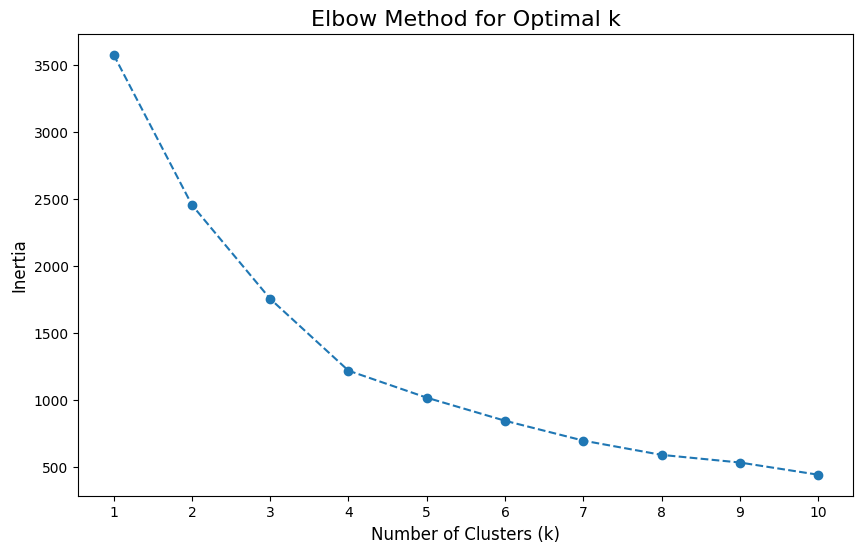

In [3]:
# --- Continue Module A: Find Optimal 'k' (Elbow Method) ---

# We need the 'features_scaled' variable from the previous cell
inertia = []
possible_k_values = range(1, 11)

for k in possible_k_values:
    # n_init=10 is the new default and silences a warning
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(possible_k_values)
plt.savefig('elbow_method_plot.png', bbox_inches='tight') # Save the plot
plt.show()

In [4]:
# --- Continue Module A: Apply Clustering ---

# Set the optimal 'k' based on your elbow plot
optimal_k = 4

# Run K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)

# Create a new 'cluster' column in your user_df
user_df['cluster'] = kmeans.fit_predict(features_scaled)

print(f"Successfully assigned all users to {optimal_k} clusters.")
print("First 5 rows with cluster assignments:")
print(user_df.head())

Successfully assigned all users to 4 clusters.
First 5 rows with cluster assignments:
                                             user_id  total_spend  \
0  AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,AHWEYO2IJ5I5GDWZA...        239.0   
1  AE23RS3W7GZO7LHYKJU6KSKVM4MQ,AEQUNEY6GQOTEGUMS...       1999.0   
2                       AE242TR3GQ6TYC6W4SJ5UYYKBTYQ        399.0   
3  AE27UOZENYSWCQVQRRUQIV2ZM7VA,AGMYSLV6NNOAYES25...       5246.0   
4  AE2JTMRKTUOIVIZWS2WDGTMNTU4Q,AF4QXCB32VC2DVE7O...       3098.0   

   review_count  average_rating  cluster  
0             1             4.4        1  
1             1             4.2        1  
2             1             4.3        1  
3             4             4.0        2  
4             2             4.4        1  


In [5]:
# --- Continue Module A: Segment Profiling ---

# Group by the new 'cluster' column and calculate the mean of each feature
segment_profiles = user_df.groupby('cluster')[['total_spend', 'review_count', 'average_rating']].mean().reset_index()

# Also, let's count how many users are in each cluster
cluster_size = user_df['cluster'].value_counts().reset_index(name='user_count')
segment_profiles = pd.merge(segment_profiles, cluster_size, on='cluster')

print("\nSegment Profiles (Averages per cluster):")
print(segment_profiles.sort_values(by='total_spend', ascending=False))


Segment Profiles (Averages per cluster):
   cluster   total_spend  review_count  average_rating  user_count
3        3  78325.666667      3.380952        4.209524          21
2        2   4199.375094      3.811321        4.167925          53
1        1   2735.955481      1.076155        4.229588         801
0        0   1636.478513      1.034810        3.695253         316


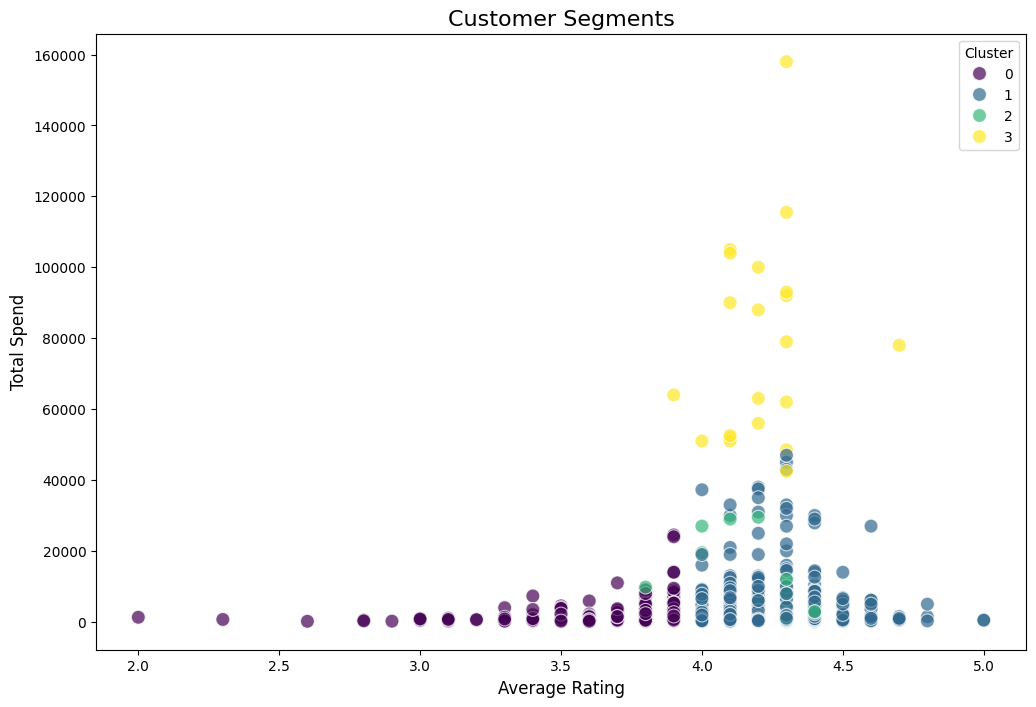

In [6]:
# --- Continue Module A: Visualize the Segments ---

# We'll use the 'user_df' which has the cluster assignment for every user
plt.figure(figsize=(12, 8))
sns.scatterplot(data=user_df,
                x='average_rating',
                y='total_spend',
                hue='cluster',  # Color the dots by their cluster
                palette='viridis', # Use a clear color palette
                alpha=0.7,
                s=100) # s is the size of the dots

plt.title('Customer Segments', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Total Spend', fontsize=12)
plt.legend(title='Cluster')
plt.savefig('customer_segment_plot.png', bbox_inches='tight') # Save the plot
plt.show()

In [7]:
# --- Section 4.2: Module B - Market Basket Analysis ---
# We'll need functions from the mlxtend library
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

print("\n--- Starting Module B: Market Basket Analysis ---")

# 1. Transaction Creation
# We create "baskets" by grouping all products reviewed by each user.
# We use the 'df_cleaned' DataFrame which is already in memory
baskets = df_cleaned.groupby('user_id')['product_name'].apply(list).reset_index(name='transactions')

# Convert to a list of lists (this is the format mlxtend needs)
transaction_list = baskets['transactions'].tolist()

print(f"Created {len(transaction_list)} baskets (one per user).")

# 2. One-Hot Encoding
# We need to install mlxtend if it's not already
try:
    from mlxtend.preprocessing import TransactionEncoder
except ImportError:
    print("Installing mlxtend...")
    !pip install mlxtend
    from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

print("Baskets successfully one-hot encoded.")
print("DataFrame shape:", basket_df.shape)
print(basket_df.head())


--- Starting Module B: Market Basket Analysis ---
Created 1191 baskets (one per user).
Baskets successfully one-hot encoded.
DataFrame shape: (1191, 1334)
   !!1000 Watt/2000-Watt Room Heater!! Fan Heater!!Pure White!!HN-2500!!Made in India!!  \
0                                              False                                      
1                                              False                                      
2                                              False                                      
3                                              False                                      
4                                              False                                      

   !!HANEUL!!1000 Watt/2000-Watt Room Heater!! Fan Heater!!Pure White!!HN-2500!!Made in India!!Thermoset!!  \
0                                              False                                                         
1                                              False                         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
# --- Continue Module B: Find Frequent Itemsets (Apriori) ---

# 1. Apply the Apriori algorithm
# We set a minimum support of 1% (0.01)
# This means the item(s) must appear in at least 1% of all 1191 baskets (or ~12 baskets)
# We use 'use_colnames=True' so we get product names, not column numbers
frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)

print("Successfully found frequent itemsets.")
print("Top 20 most frequent itemsets (sorted by support):")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(20))

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Successfully found frequent itemsets.
Top 20 most frequent itemsets (sorted by support):
Empty DataFrame
Columns: [support, itemsets]
Index: []


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [9]:
# --- Continue Module B: Re-run Apriori and Generate Rules ---

# 1. Re-run Apriori with a much lower support threshold
# We'll try 0.2% (or 0.002)
frequent_itemsets = apriori(basket_df, min_support=0.002, use_colnames=True)

if frequent_itemsets.empty:
    print("Still no frequent itemsets found. The dataset is extremely sparse.")
    print("You may need to try an even lower min_support or check your data.")
else:
    print("Successfully found frequent itemsets with new support.")

    # 2. Generate the Association Rules
    # We are looking for rules with a 'lift' > 1
    # and a 'confidence' > 0.1 (or 10%)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    if rules.empty:
        print("No association rules found with lift > 1.")
    else:
        # Sort the rules by 'lift' and 'confidence' to see the strongest relationships
        top_rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])

        print("\n--- Top Association Rules ---")
        # We only want to see the key columns
        print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Still no frequent itemsets found. The dataset is extremely sparse.
You may need to try an even lower min_support or check your data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [10]:
# --- Section 4.3: Module C - Sentiment Analysis ---
print("\n--- Starting Module C: Sentiment Analysis ---")

# We need the TextBlob library for sentiment analysis
try:
    from textblob import TextBlob
except ImportError:
    print("Installing TextBlob...")
    !pip install textblob
    from textblob import TextBlob

# 1. Define Sentiment Scoring Functions
# We'll analyze both the review title and the content

def get_polarity(text):
    """Calculates polarity (positive/negative)"""
    return TextBlob(str(text)).sentiment.polarity

def get_subjectivity(text):
    """Calculates subjectivity (objective/subjective)"""
    return TextBlob(str(text)).sentiment.subjectivity

# 2. Apply Sentiment Scoring
# We use the 'df_cleaned' DataFrame which has our reviews
print("Calculating sentiment scores for all reviews... (this may take a moment)")

# Make sure review columns are strings
df_cleaned['review_title'] = df_cleaned['review_title'].astype(str)
df_cleaned['review_content'] = df_cleaned['review_content'].astype(str)

# Create new sentiment columns
df_cleaned['polarity'] = df_cleaned['review_content'].apply(get_polarity)
df_cleaned['subjectivity'] = df_cleaned['review_content'].apply(get_subjectivity)

print("Sentiment scoring complete.")

# 3. Display Results
# Show the new columns alongside the review and rating
print(df_cleaned[['rating', 'review_content', 'polarity', 'subjectivity']].head())

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- Starting Module C: Sentiment Analysis ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Calculating sentiment scores for all reviews... (this may take a moment)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Sentiment scoring complete.
   rating                                     review_content  polarity  \
0     4.2  Looks durable Charging is fine tooNo complains...  0.481944   
1     4.0  I ordered this cable to connect my phone to An...  0.274318   
2     3.9  Not quite durable and sturdy,https://m.media-a...  0.600000   
3     4.2  Good product,long wire,Charges good,Nice,I bou...  0.240370   
4     4.2  Bought this instead of original apple, does th...  0.262740   

   subjectivity  
0      0.675000  
1      0.509394  
2      1.000000  
3      0.544444  
4      0.642634  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [11]:
# --- Continue Module C: Aggregate Sentiment by Product ---

# Group by product name and calculate the mean polarity
# Also count the number of reviews for context
product_sentiment = df_cleaned.groupby('product_name').agg(
    average_polarity=('polarity', 'mean'),
    review_count=('review_id', 'count')
).reset_index()

print("Average sentiment polarity per product:")
print(product_sentiment.head())

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Average sentiment polarity per product:
                                        product_name  average_polarity  \
0  !!1000 Watt/2000-Watt Room Heater!! Fan Heater...          0.260417   
1  !!HANEUL!!1000 Watt/2000-Watt Room Heater!! Fa...          0.357353   
2  10WeRun Id-116 Bluetooth Smartwatch Wireless F...          0.505556   
3  10k 8k 4k HDMI Cable, Certified 48Gbps 1ms Ult...          0.420312   
4  3M Post-it Sticky Note Cube, 200 Sheets (4 Col...          0.600000   

   review_count  
0             1  
1             1  
2             1  
3             1  
4             1  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

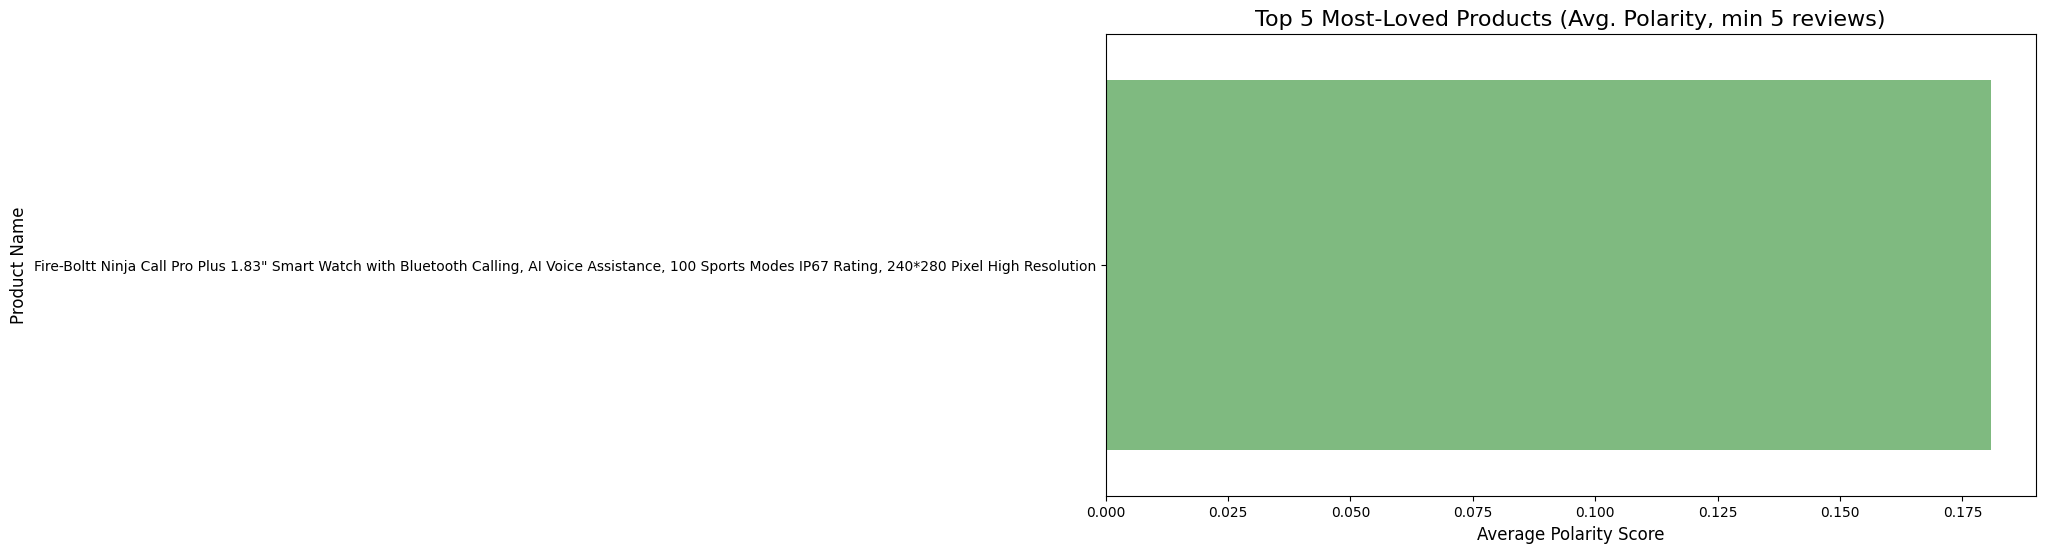

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

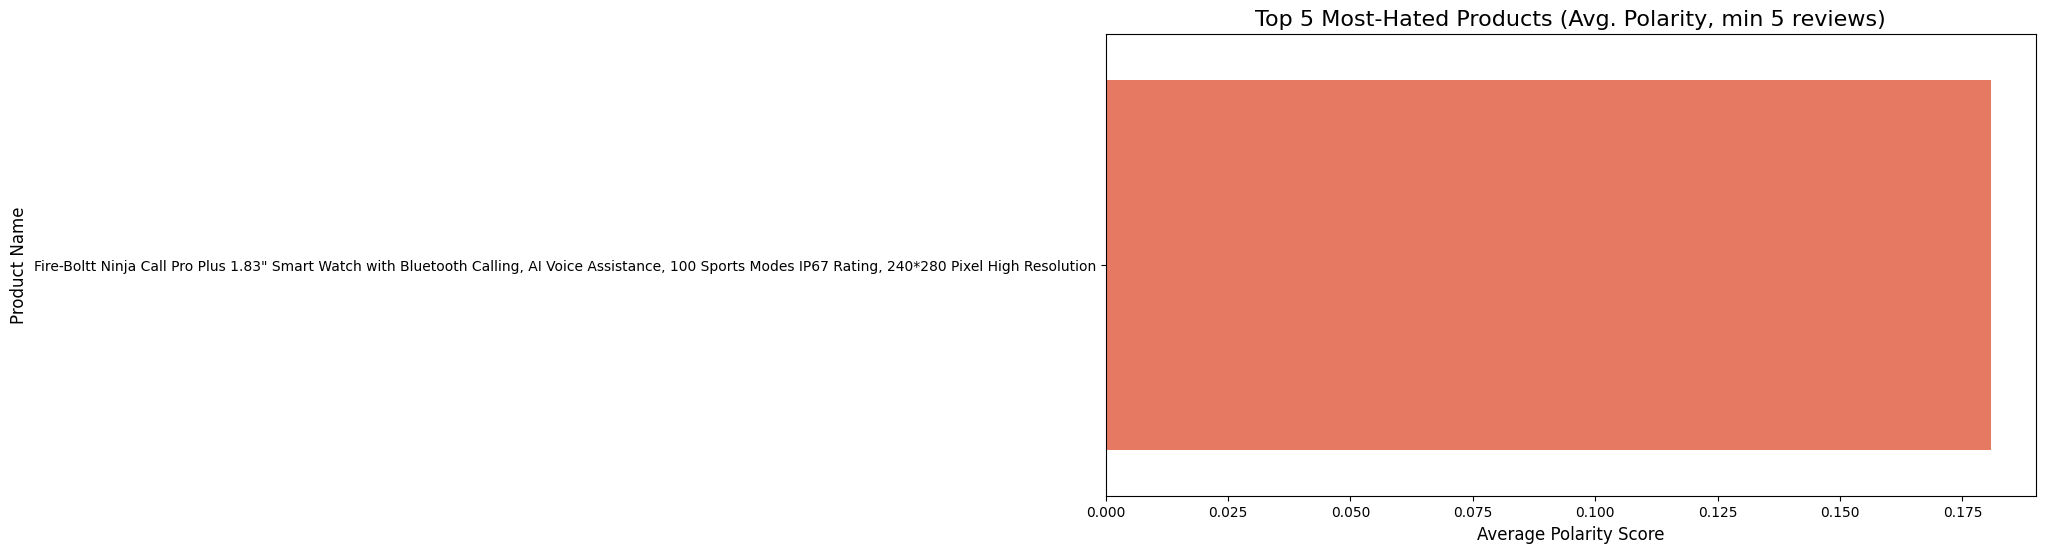

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [12]:
# --- Continue Module C: Top & Bottom Products by Sentiment ---

# Filter for products with a reasonable number of reviews (e.g., >= 5)
product_sentiment_filtered = product_sentiment[product_sentiment['review_count'] >= 5]

# Get top 5 most-loved
most_loved = product_sentiment_filtered.nlargest(5, 'average_polarity')

# Get top 5 most-hated (lowest polarity)
most_hated = product_sentiment_filtered.nsmallest(5, 'average_polarity')

# Plot Most-Loved
plt.figure(figsize=(12, 6))
sns.barplot(data=most_loved, x='average_polarity', y='product_name', palette='Greens_r')
plt.title('Top 5 Most-Loved Products (Avg. Polarity, min 5 reviews)', fontsize=16)
plt.xlabel('Average Polarity Score', fontsize=12)
plt.ylabel('Product Name', fontsize=12)
plt.xlim(0, None) # Start x-axis at 0 for positive sentiment
plt.show()

# Plot Most-Hated
plt.figure(figsize=(12, 6))
sns.barplot(data=most_hated, x='average_polarity', y='product_name', palette='Reds_r')
plt.title('Top 5 Most-Hated Products (Avg. Polarity, min 5 reviews)', fontsize=16)
plt.xlabel('Average Polarity Score', fontsize=12)
plt.ylabel('Product Name', fontsize=12)
plt.show()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

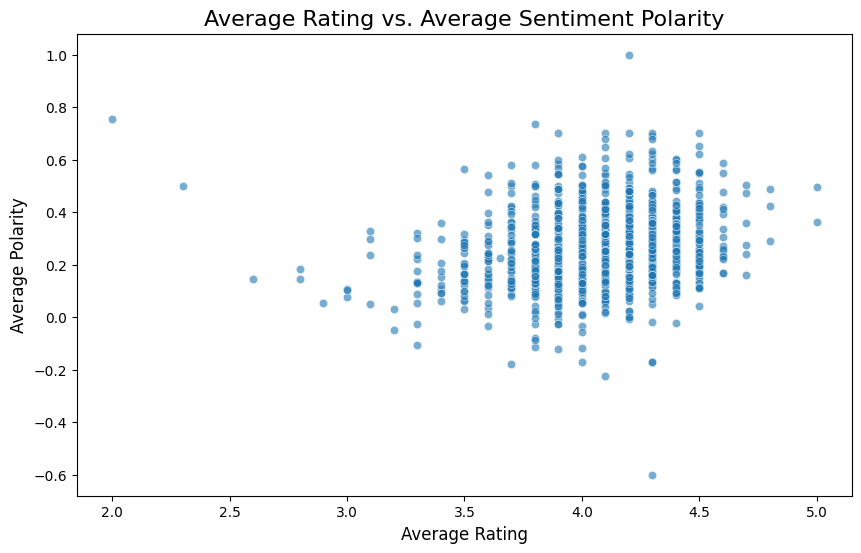

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

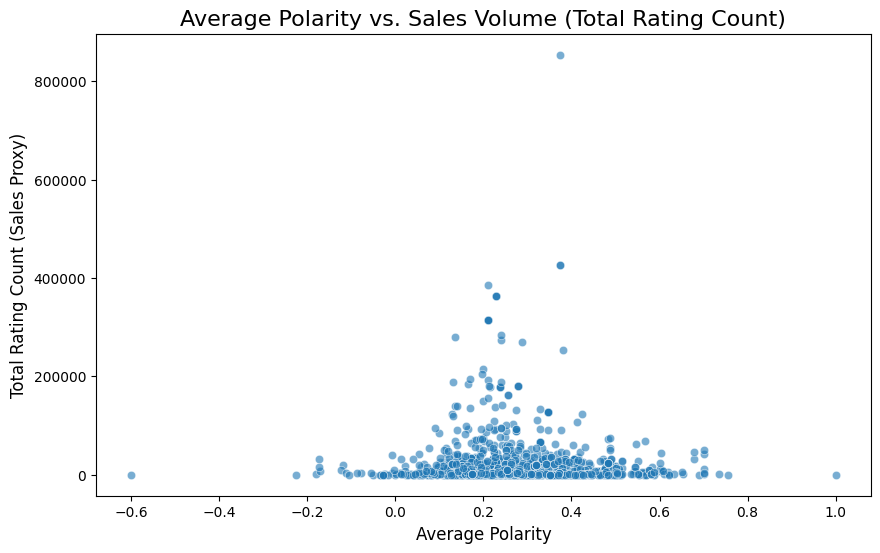

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [13]:
# --- Continue Module C: Correlate Sentiment ---

# Need to merge sentiment data back with average rating and total rating count
# First, aggregate rating and rating_count by product
product_ratings = df_cleaned.groupby('product_name').agg(
    average_rating=('rating', 'mean'),
    total_rating_count=('rating_count', 'sum') # Sum of counts as proxy for sales
).reset_index()

# Merge sentiment and ratings data
product_analysis_df = pd.merge(product_sentiment, product_ratings, on='product_name')

# Plot 1: Average Rating vs. Average Polarity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_analysis_df, x='average_rating', y='average_polarity', alpha=0.6)
plt.title('Average Rating vs. Average Sentiment Polarity', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Average Polarity', fontsize=12)
plt.show()

# Plot 2: Average Polarity vs. Sales Volume (Total Rating Count)
# This helps build the 2x2 matrix you planned
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_analysis_df, x='average_polarity', y='total_rating_count', alpha=0.6)
plt.title('Average Polarity vs. Sales Volume (Total Rating Count)', fontsize=16)
plt.xlabel('Average Polarity', fontsize=12)
plt.ylabel('Total Rating Count (Sales Proxy)', fontsize=12)
# Optional: Add lines to visualize the 2x2 matrix quadrants
# plt.axhline(product_analysis_df['total_rating_count'].median(), color='grey', linestyle='--')
# plt.axvline(0.1, color='grey', linestyle='--') # Example threshold for positive polarity
plt.show()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- Starting Part 5: Demand Forecasting ---
Created weekly time series data:
date
2022-01-02    2
2022-01-09    7
2022-01-16    7
2022-01-23    7
2022-01-30    7
Freq: W-SUN, Name: review_count_weekly, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

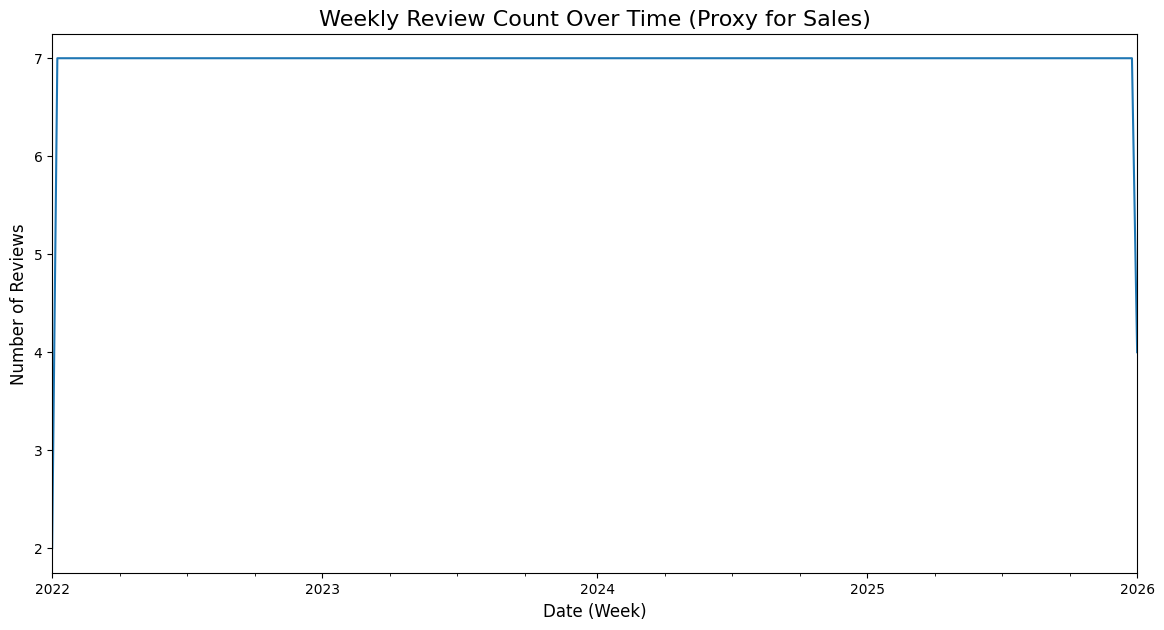

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [14]:
# --- Part 5: Strategic Forecasting ---
# --- Section 5.1: Demand Forecasting with Time Series Analysis ---
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd # Make sure pandas is imported

print("\n--- Starting Part 5: Demand Forecasting ---")

# 1. Time Series Data Preparation
# Assumption: Row order approximates time. We aggregate by week.
# We'll create an artificial date range for demonstration.

# Reset index to ensure it's sequential
df_cleaned_ts = df_cleaned.reset_index()

# Create an artificial date range starting from an arbitrary past date
# One date per row, assuming rows are chronologically ordered (MAJOR ASSUMPTION)
start_date = '2022-01-01' # Arbitrary start date
dates = pd.date_range(start=start_date, periods=len(df_cleaned_ts), freq='D') # Assume one review per day average

df_cleaned_ts['date'] = dates
df_cleaned_ts.set_index('date', inplace=True)

# Aggregate review counts by week (Resample)
# We count the number of reviews ('index' or any non-null column) per week
weekly_reviews = df_cleaned_ts['index'].resample('W').count()

# Rename for clarity
weekly_reviews = weekly_reviews.rename('review_count_weekly')

print("Created weekly time series data:")
print(weekly_reviews.head())

# Plot the time series
plt.figure(figsize=(14, 7))
weekly_reviews.plot()
plt.title('Weekly Review Count Over Time (Proxy for Sales)', fontsize=16)
plt.xlabel('Date (Week)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

In [15]:
# --- Continue Part 5: Stationarity Check ---
from statsmodels.tsa.stattools import adfuller

print("\n--- Checking for Stationarity ---")

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(weekly_reviews.dropna()) # dropna() just in case

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

# Interpret the p-value
if adf_result[1] <= 0.05:
    print("\nResult: Reject the null hypothesis (H0). The time series is likely stationary.")
    is_stationary = True
else:
    print("\nResult: Fail to reject the null hypothesis (H0). The time series is likely non-stationary.")
    is_stationary = False


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- Checking for Stationarity ---
ADF Statistic: -24.04860619374375
p-value: 0.0
Critical Values:
	1%: -3.4620315036789666
	5%: -2.8754705024827127
	10%: -2.5741950726860647

Result: Reject the null hypothesis (H0). The time series is likely stationary.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- Plotting ACF and PACF ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

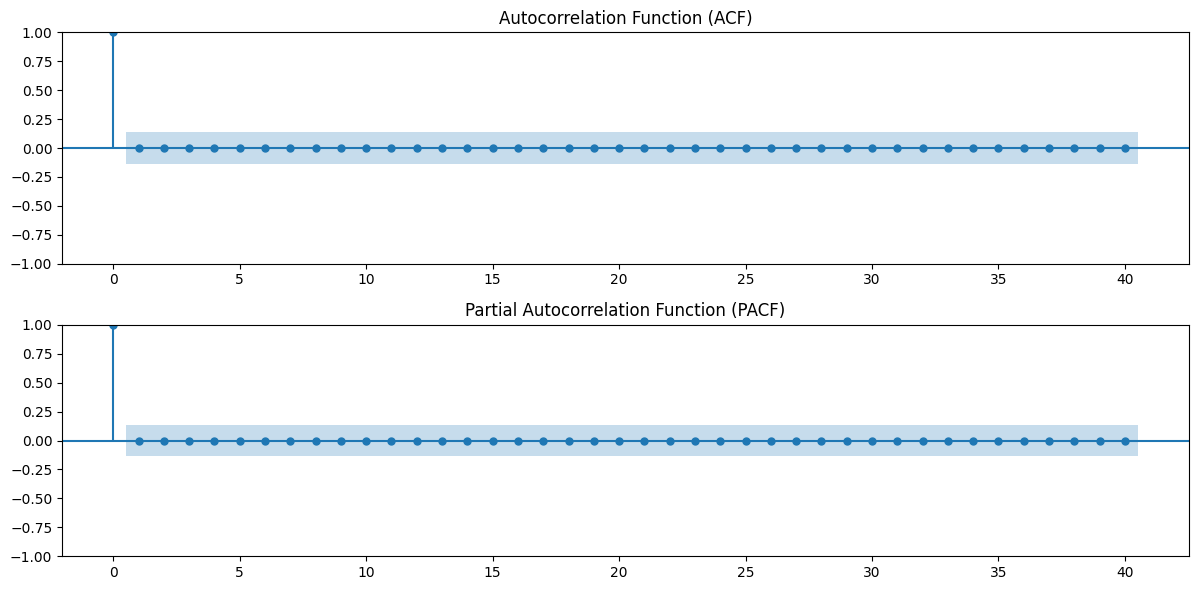

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [16]:
# --- Continue Part 5: ACF and PACF Plots ---
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print("\n--- Plotting ACF and PACF ---")

# Ensure plots are displayed correctly
plt.figure(figsize=(12, 6))

# Plot ACF
ax1 = plt.subplot(211) # 2 rows, 1 column, plot 1
plot_acf(weekly_reviews.dropna(), ax=ax1, lags=40) # Show up to 40 lags
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF
ax2 = plt.subplot(212) # 2 rows, 1 column, plot 2
plot_pacf(weekly_reviews.dropna(), ax=ax2, lags=40) # Show up to 40 lags
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- Training ARIMA Model ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

ARIMA model trained successfully.
                                SARIMAX Results                                
Dep. Variable:     review_count_weekly   No. Observations:                  210
Model:                  ARIMA(1, 0, 1)   Log Likelihood                -105.853
Date:                 Fri, 24 Oct 2025   AIC                            219.706
Time:                         15:23:04   BIC                            233.095
Sample:                     01-02-2022   HQIC                           225.119
                          - 01-04-2026                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9619      0.179     38.995      0.000       6.612       7.312
ar.L1       -2.65e-05   1.59e+04  -1.67e-09      1.000   -3.11e+04    3.11e+04
ma.L1     

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

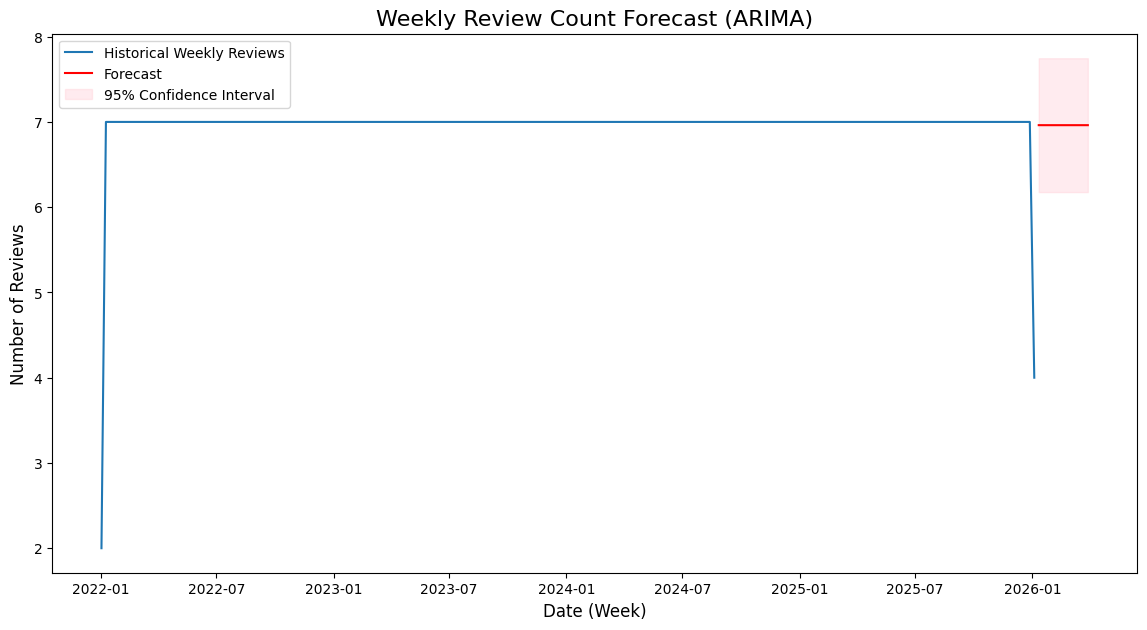

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [17]:
# --- Continue Part 5: Train ARIMA and Forecast ---
from statsmodels.tsa.arima.model import ARIMA

print("\n--- Training ARIMA Model ---")

# Define the ARIMA model order (p, d, q)
arima_order = (1, 0, 1)

# Create and train the ARIMA model
# We use the entire 'weekly_reviews' series for training
model = ARIMA(weekly_reviews, order=arima_order)
model_fit = model.fit()

print("ARIMA model trained successfully.")
print(model_fit.summary())

# --- Generate Forecast ---
print("\n--- Generating Forecast ---")

# Define how many steps (weeks) to forecast ahead
forecast_steps = 12 # Forecast the next 12 weeks

# Get the forecast, standard error, and confidence intervals
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int(alpha=0.05) # 95% confidence interval

# Create date index for the forecast period
last_date = weekly_reviews.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')

# Combine forecast mean and confidence intervals into a DataFrame
forecast_df = pd.DataFrame({
    'forecast': forecast_mean.values,
    'lower_ci': confidence_intervals.iloc[:, 0].values,
    'upper_ci': confidence_intervals.iloc[:, 1].values
}, index=forecast_index)

print("Forecast generated:")
print(forecast_df)

# --- Visualize Forecast ---
print("\n--- Visualizing Forecast ---")

plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(weekly_reviews.index, weekly_reviews, label='Historical Weekly Reviews')

# Plot forecast mean
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red')

# Plot confidence intervals
plt.fill_between(forecast_df.index,
                 forecast_df['lower_ci'],
                 forecast_df['upper_ci'],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Weekly Review Count Forecast (ARIMA)', fontsize=16)
plt.xlabel('Date (Week)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend()
plt.show()